In [49]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

#Setting up the Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MegaVector_2 = pd.read_csv("xyzVector.csv").to_numpy()
targets_2 = pd.read_csv("targets_2.csv").to_numpy()
#Retrieving the Data from CSV files
MegaVector = pd.read_csv("signals.csv").to_numpy()
targets = pd.read_csv("targets.csv").to_numpy()
n_features = MegaVector.shape[0]
#Converting the Data to a Torch Tensor for training and GPU parallel computing
MegaVector_t = torch.from_numpy(MegaVector.astype(np.float32)).to(device)
targets_t = torch.from_numpy(targets.astype(np.float32)).to(device)

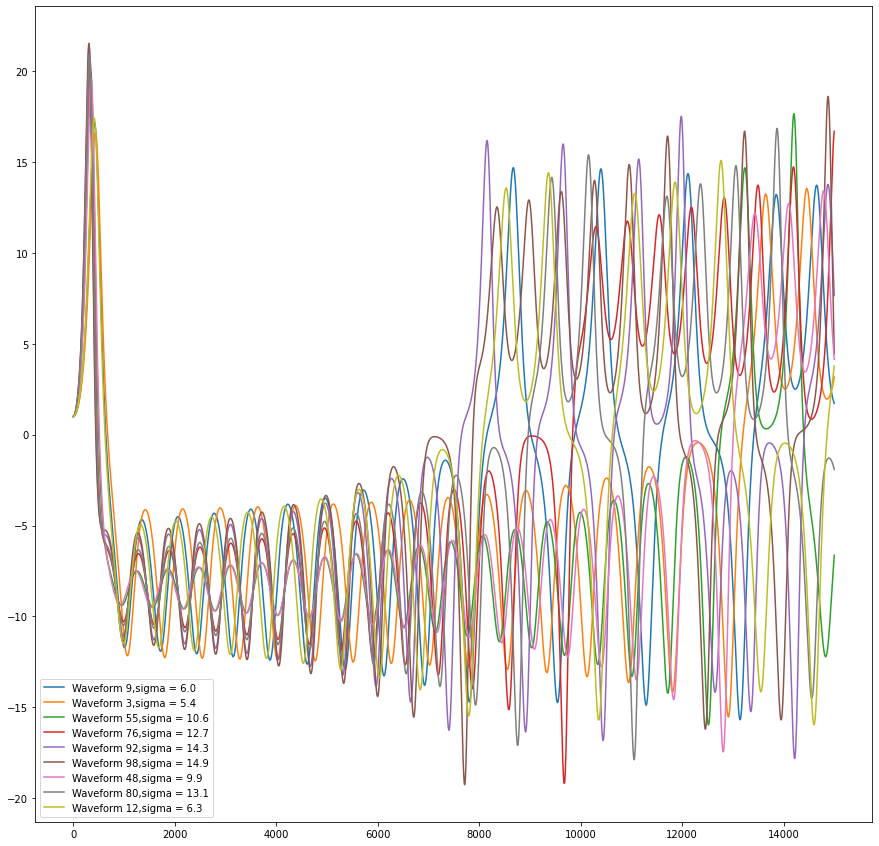

In [50]:
#Data Visualization
import matplotlib.pyplot as plt
idx_array = []
plt.figure(figsize = [15, 15])
cols, rows = 3,3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(targets_t), size = (1,)).item()
    waveform = MegaVector[:,sample_idx]
    #Matplotlib pyplot library works only with
    line = plt.plot(waveform, label=f"Waveform {str(sample_idx)},sigma = {targets[sample_idx].item()}")
    idx_array.append(sample_idx)

plt.legend()
plt.show()

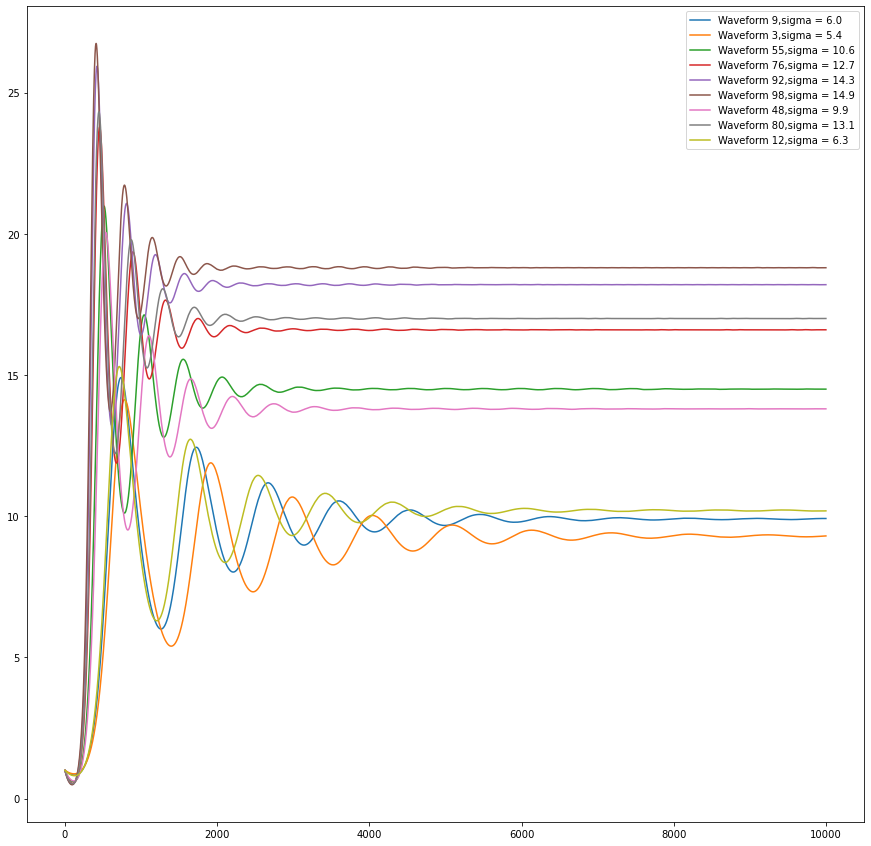

In [51]:
plt.figure(figsize = [15,15])
for sample in idx_array:
    waveform = MegaVector_2[:,sample*3+2]
    #Matplotlib pyplot library works only with
    line = plt.plot(waveform, label=f"Waveform {str(sample)},sigma = {targets_2[sample*3+2,0].item()}")
plt.legend()
plt.show()

In [52]:
print(idx_array[0])
print(targets_2[idx_array[0]*3+2,0])
print(targets[idx_array[0]])

9
6.0
[6.]


In [53]:
#Network Layer design
class ParametersPredictor(nn.Module):
    def __init__(self, n_input_features):
        super(ParametersPredictor, self).__init__()
        self.linear = nn.Linear(n_input_features, 1000)
        self.linear2 = nn.Linear(1000, 1000)
        self.relu1 = nn.ReLU()
        self.linear3 = nn.Linear(1000, 1000)
        self.relu2 = nn.ReLU()
        self.linear4 = nn.Linear(1000, 1000)
        self.relu3 = nn.ReLU()
        self.linear5 = nn.Linear(1000, 1)


    def forward(self, x):
        out = self.linear(x)
        out = self.linear2(out)
        out = self.relu1(out)
        out = self.linear3(out)
        out = self.relu2(out)
        out = self.linear4(out)
        out = self.relu3(out)
        out = self.linear5(out)
        return out

In [ ]:
#Training Loop
learning_rate = 0.0001
NeuralNetwork = ParametersPredictor(n_features).to(device)
batch_size = targets_t.shape[0]
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=learning_rate)
total_loss = 0
EPOCHS = 1000
for epoch in tqdm(range(EPOCHS)):
    for i in range(batch_size):
        predicted_y = NeuralNetwork.forward(MegaVector_t[:,i])
        loss = criterion(targets_t[i], predicted_y)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # updates
        optimizer.step()
        total_loss += loss/batch_size

        # zero gradients
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}. Loss: {total_loss:.8f}")
    if total_loss < 1:
        optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=0.000001)
    elif total_loss < 0.1:
        optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=0.000000001)
    elif total_loss < 0.001:
        optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=1e-11)
    elif total_loss < 0.00001:
        optimizer = torch.optim.Adam(NeuralNetwork.parameters(), lr=1e-14)
    total_loss = 0

In [55]:
print(NeuralNetwork.forward(MegaVector_t[:,0]).item())
print(targets_t[0].item())

5.105487823486328
5.099999904632568


In [65]:
print(NeuralNetwork.forward(MegaVector_t[:,50]).item())
print(targets_t[50].item())

9.811161994934082
10.100000381469727


In [57]:
print(NeuralNetwork(MegaVector_t[:,17]).item())
print(targets_t[17].item())

6.800066947937012
6.800000190734863


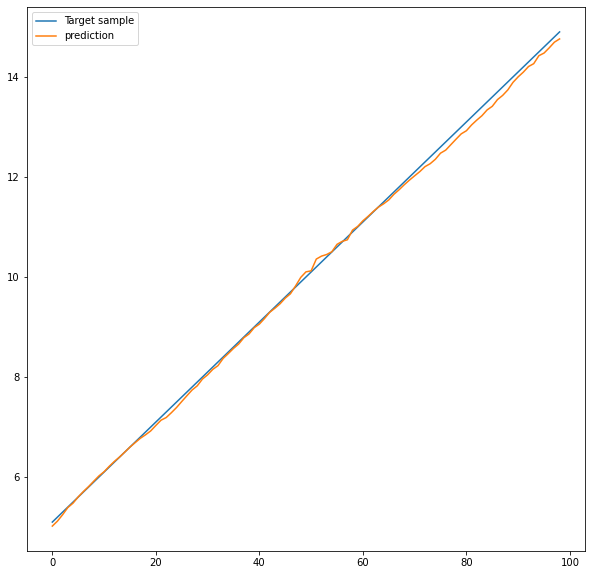

In [88]:
import matplotlib.pyplot as plt
predictions = []
for i in range(batch_size):
    predictions.append(NeuralNetwork(MegaVector_t[:,i]).item())

predictions = np.array(predictions)
plt.figure(figsize = [10,10])
plt.plot(targets, label="Target sample")
plt.plot(predictions, label="prediction")
plt.legend()
plt.show()

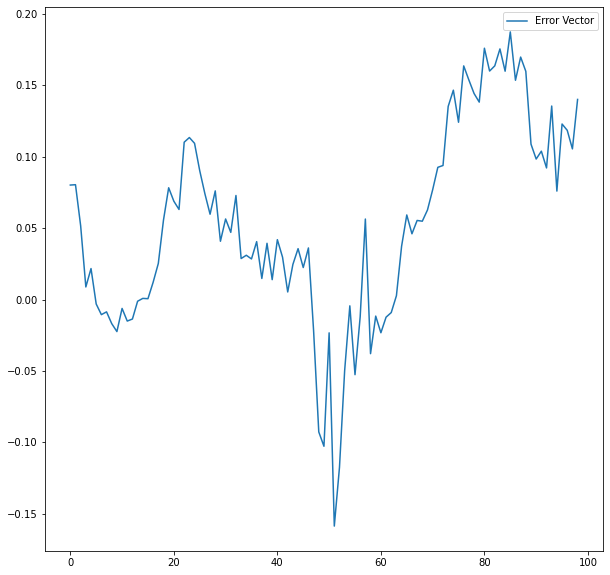

Error mean: 0.052564996661561905


In [90]:
predictions = predictions.reshape(99,1)
error_vector = targets - predictions
plt.figure(figsize = [10,10])
plt.plot(error_vector, label = "Error Vector")
plt.legend()
plt.show()
print(f"Error mean: {error_vector.mean()}")

In [14]:
#Saving the Neural Network with the trained weights and biases
SAVE_PATH = r"C:\Users\Tatonta\Desktop\Deep Learning\ParametersPrediction.pth"
torch.save(NeuralNetwork, SAVE_PATH)

In [87]:
# The following code is needed to load the Neural Network on another computer
# The Neural Network class must be preemptively declared before loading it from the .pth file
## NeuralNetwork = torch.load(NN_PATH, map_location = device)
# NN_PATH is where the .pth file with the trained network is located in your computer directories
# map_location = device is necessary in order to have the Network work properly on CPU-only computer hardware
# NeuralNetwork.eval()
#The Neural Network is finally ready for inference

ParametersPredictor(
  (linear): Linear(in_features=14999, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=1000, bias=True)
  (relu1): ReLU()
  (linear3): Linear(in_features=1000, out_features=1000, bias=True)
  (relu2): ReLU()
  (linear4): Linear(in_features=1000, out_features=1000, bias=True)
  (relu3): ReLU()
  (linear5): Linear(in_features=1000, out_features=1, bias=True)
)